In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from sklearn.externals.six import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
from sklearn.datasets import load_iris, load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(iris_X, iris_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = iris_X[:, 0], iris_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=iris_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [3]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [4]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

# Использование [ансамблевых моделей](https://ru.wikipedia.org/wiki/%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D1%8C_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%B2_(%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD)) (или композиции моделей). Часть 2.

Идея использования ансамблевых моделей состоит в том, что оценивается результат совместного голосования различных моделей. Варианты объединения моделей в ансамбль могут быть различными и могут использоваться для решения различных задач.

В ансамблевых моделях часто используют такие термины как "сильный ученик" или "сильная модель" (strong learner) и "слабый ученик" или "слабая модель" (weak learner). На основе набора "слабых моделей" строится ансамбль, который является "сильной моделью".

Использование ансамблевых моделей поддерживается в [scikit-learn,](https://scikit-learn.org/stable/modules/ensemble.html) и также в других библиотеках.

### Часть 2:
1. Стекинг и блендинг
1. Метод группового учета аргументов

К ансамблевым моделям также относятся нейросетевые модели, но в данном курсе они не рассматриваются.

- **Дополнительно: автоматическое обучение (AutoML).**

## [Стекинг и блендинг](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking)

Термины "стекинг" и "блендинг" иногда используют как синонимы (что не совсем корректно). Блендинг можно считать упрощенным вариантом стекинга.

Во всех ансамблевых моделях явно или неявно используется модель верхнего уровня. В стекинге для такой модели используется явное название **мета-ученик (meta-learner)** или **модель 2 уровня (level 2 model)**.

В моделях на основе бэггинга (бэггинг, случайного леса, сверхслучайные деревья) в качестве модели 2 уровня используется усреднение результатов голосования моделей.

В моделях на основе бустинга используется взвешенная сумма результатов голосования моделей. Бустинг может рассматриваться как разновидность линейной регресии, где регрессорами являются выходы "слабых моделей".

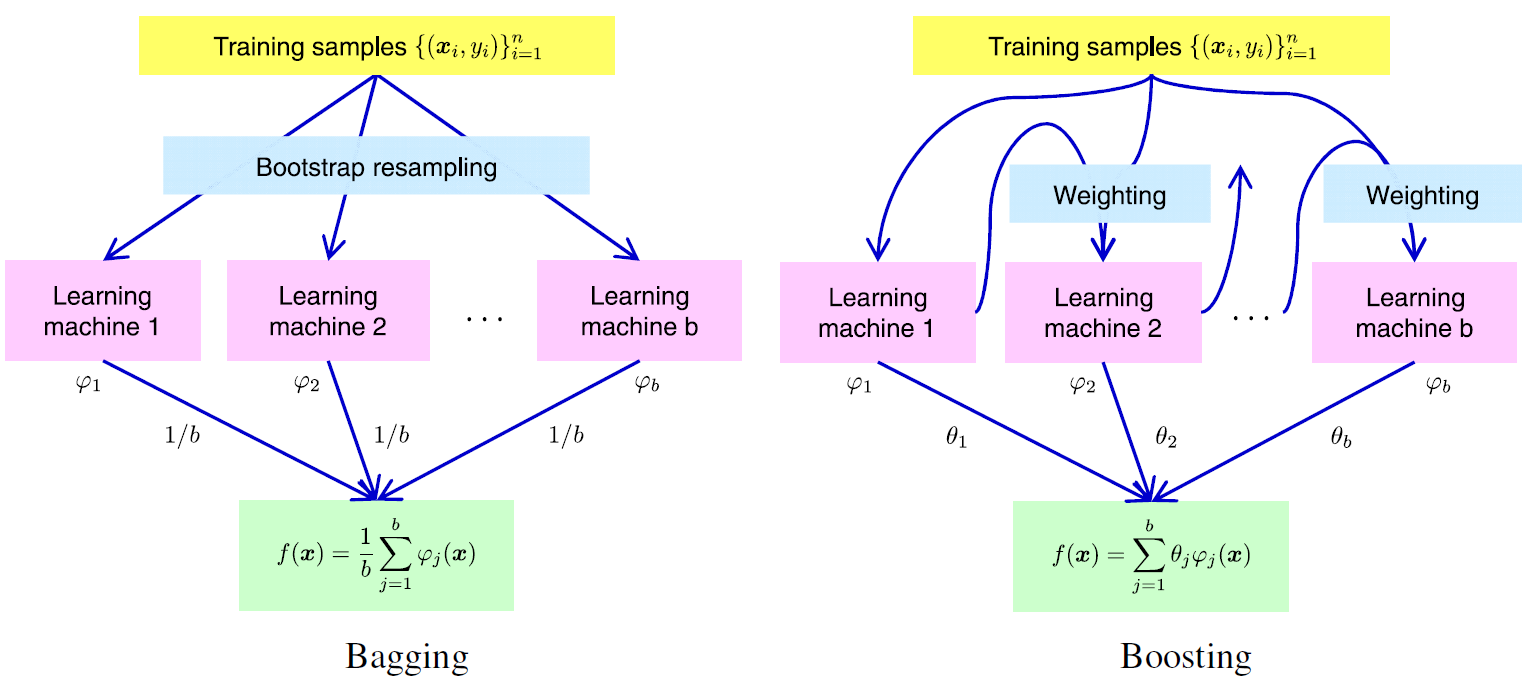

In [5]:
Image('img/boosting.png', width='55%')

Стекинг принципиальноо отличается от моделей на основе бэггинга и бустинга следующим:
1. Мета-ученик является отдельной моделью машинного обучения, 
выходы "слабых моделей" рассматриваются как входные признаки 
для мета-ученика.

1. В качестве "слабых моделей" рассматриваются различные модели, которые дают различные результаты. Эти результаты рассматриваются как входные признаки для мета-ученика. 

Идея стекинга показана на следующем рисунке:

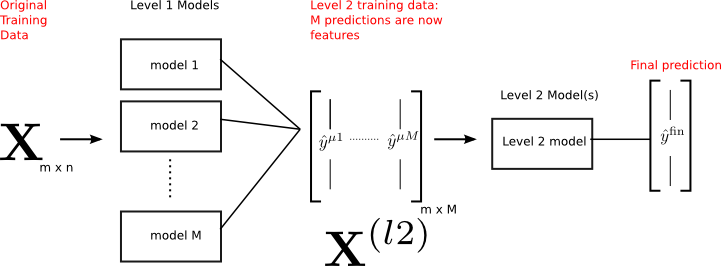

In [6]:
#Источник - https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html
Image('img/stacking.png', width='100%')

Модели 1 уровня обычно сложные и использующие различные алгоритмы, например SVM, дерево решений, случайный лес и т.д. Использование различных алгоритмов, фактически, обеспечивает дисперсию внутри модели, а также исключает возможность возникновения линейной зависимости между признаками, поступающими на вход модели 2 уровня.

Модели 2 уровня обычно простые. Часто используются линейные модели. Например для задачи регрессии - линейная регрессия, для задачи классификации - логистическая регрессия. 

Концепции стекинга и блендинга очень детально рассмотрены в [блоге профессора Александра Геннадьевича Дьяконова.](https://dyakonov.org/2017/03/10/c%d1%82%d0%b5%d0%ba%d0%b8%d0%bd%d0%b3-stacking-%d0%b8-%d0%b1%d0%bb%d0%b5%d0%bd%d0%b4%d0%b8%d0%bd%d0%b3-blending/)

### Эксперименты

В scikit-learn данная модель не реализована напрямую. Она реализована в библиотеке [heamy.](https://heamy.readthedocs.io/en/latest/)

In [7]:
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [8]:
boston = load_boston()
boston_X, boston_y = boston['data'], boston['target']
boston_X_train, boston_X_test, boston_y_train, boston_y_test = train_test_split(
    boston_X, boston_y, test_size=0.2, random_state=1)

In [9]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(boston_X_train, boston_y_train)
    y_pred = model.predict(boston_X_test)
    result = mean_absolute_error(boston_y_test, y_pred)
    print(model)
    print('MAE={}'.format(result))

In [10]:
# Точность на отдельных моделях
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=50)
]:
    val_mae(model)
    print('==========================')
    print()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MAE=3.7507121808389168

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
MAE=2.953921568627451

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbo

In [11]:
# Используем библиотеку heamy
# набор данных
dataset = Dataset(boston_X_train, boston_y_train, boston_X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [12]:
# Эксперимент 1
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.2732855390954505, 2.4057163991038144, 2.3940028938918596, 3.062465604660772, 2.9473463485924056, 2.653565368240077, 2.657112334558009, 2.53683179257099, 2.6427782276499685, 3.193399523560955]
Mean accuracy: 2.6766504031924305
Standard Deviation: 0.2875358418931061
Variance: 0.0826768603731773


In [13]:
# Эксперимент 2
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: случайный лес

stacker = Regressor(dataset=stack_ds, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.5358536585365874, 2.449829268292681, 2.3774146341463376, 3.455951219512197, 2.807325000000003, 2.7213500000000024, 2.084374999999997, 2.8247749999999985, 2.4680000000000013, 3.050600000000002]
Mean accuracy: 2.6775473780487804
Standard Deviation: 0.36650969400738626
Variance: 0.13432935580138788


In [14]:
# Эксперимент 3
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [1.81855120406732, 2.149094933334621, 2.0151300509276426, 3.2138360582103065, 2.5049742859274717, 2.1300134344739385, 2.433971337542571, 2.3853333560377914, 2.1541958928407263, 2.1932855893484366]
Mean accuracy: 2.2998386142710823
Standard Deviation: 0.3604995208538116
Variance: 0.12995990453582776


In [15]:
# Эксперимент 4
# Первый уровень - три модели: дерево, линейная регрессия и случайный лес
# Второй уровень: случайный лес
# Результат хуже чем в эксперименте 3
stacker = Regressor(dataset=stack_ds3, estimator=RandomForestRegressor)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [2.0469999999999984, 2.541073170731706, 2.0407317073170685, 3.025024390243902, 2.49895, 2.498125000000002, 2.656575, 2.2167750000000015, 2.111374999999999, 2.4294750000000014]
Mean accuracy: 2.406510426829268
Standard Deviation: 0.29441652349645325
Variance: 0.08668108930773762


In [16]:
# Результаты
array_labels = ['LR','TREE', 'RF', 'TREE+LR=>LR', 
                'TREE+LR=>RF', 'TREE+LR+RF=>LR', 'TREE+LR+RF=>RF']
array_mae = [3.7507121808389168, 2.942156862745098, 2.263039215686275, 
             2.6766504031924305, 2.6775473780487804, 2.2998386142710823, 
             2.406510426829268]

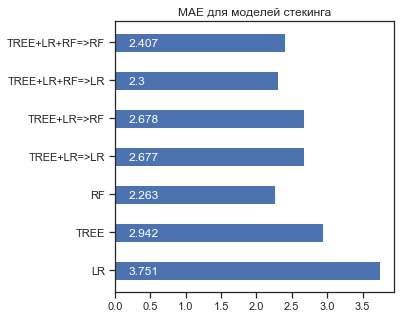

In [17]:
# Визуализация результатов
vis_models_quality(array_mae, array_labels, 'MAE для моделей стекинга')

Вывод: лучший результат стекинга сравним с наиболее сильной моделью 1 уровня (случайным лесом).

В сообществе анализа данных существует афоризм, что "стекинг - не технология серебряной пули, а технология последней мили".

За счет того, что модель стекинга слабо поддается интерпертации, в основном эта модель используется тогда, когда нужно улучшить качество модели на конкретном наборе данных. Например, в соревнованиях по анализу данных.

### Дополнительные источники (по стекингу)
- [Блог Александра Дьяконова. Cтекинг (Stacking) и блендинг (Blending)](https://dyakonov.org/2017/03/10/c%d1%82%d0%b5%d0%ba%d0%b8%d0%bd%d0%b3-stacking-%d0%b8-%d0%b1%d0%bb%d0%b5%d0%bd%d0%b4%d0%b8%d0%bd%d0%b3-blending/)
- https://neurohive.io/ru/osnovy-data-science/ansamblevye-metody-begging-busting-i-steking/
- https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de
- https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

## [Метод группового учета аргументов](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D1%80%D1%83%D0%BF%D0%BF%D0%BE%D0%B2%D0%BE%D0%B3%D0%BE_%D1%83%D1%87%D1%91%D1%82%D0%B0_%D0%B0%D1%80%D0%B3%D1%83%D0%BC%D0%B5%D0%BD%D1%82%D0%BE%D0%B2)

Англ. [Group method of data handling](https://en.wikipedia.org/wiki/Group_method_of_data_handling) (GMDH).

Избретен в СССР академиком [А.Г.Ивахненко.](https://ru.wikipedia.org/wiki/%D0%98%D0%B2%D0%B0%D1%85%D0%BD%D0%B5%D0%BD%D0%BA%D0%BE,_%D0%90%D0%BB%D0%B5%D0%BA%D1%81%D0%B5%D0%B9_%D0%93%D1%80%D0%B8%D0%B3%D0%BE%D1%80%D1%8C%D0%B5%D0%B2%D0%B8%D1%87)


Давайте вспомним дилемму смещения–дисперсии и проблему переобучения моделей.

- [Детальная статья про переобучение](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D0%B5%D1%80%D0%B5%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5) 
- [Раздел про переобучение из scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)
- [Дилемма смещения–дисперсии](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D0%BB%D0%B5%D0%BC%D0%BC%D0%B0_%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D1%8F%E2%80%93%D0%B4%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D0%B8)

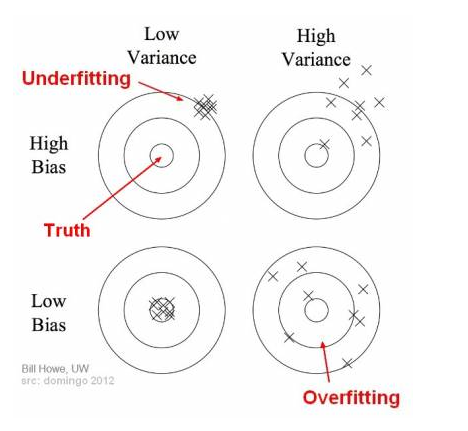

In [18]:
Image('img/bv1.png', width='70%')

**Возможно ли создать метод, в алгоритмы которого была бы заложено преодоление проблемы переобучения? Да, и это МГУА.**

[Презентация](http://www.machinelearning.ru/wiki/images/6/65/DM_L3-2_part1.pdf) с детальным описанием работы метода.

Краткая идея метода заключается в том, что метод напоминает глубокую нейронную сеть. Но слои нейронной сети выращиваются с помощью эволюционных методов (разновидностей генетического алгоритма) до тех пор пока растет качество модели и еще не наступает переобучение.

Идея МГУА показана на следующем рисунке:

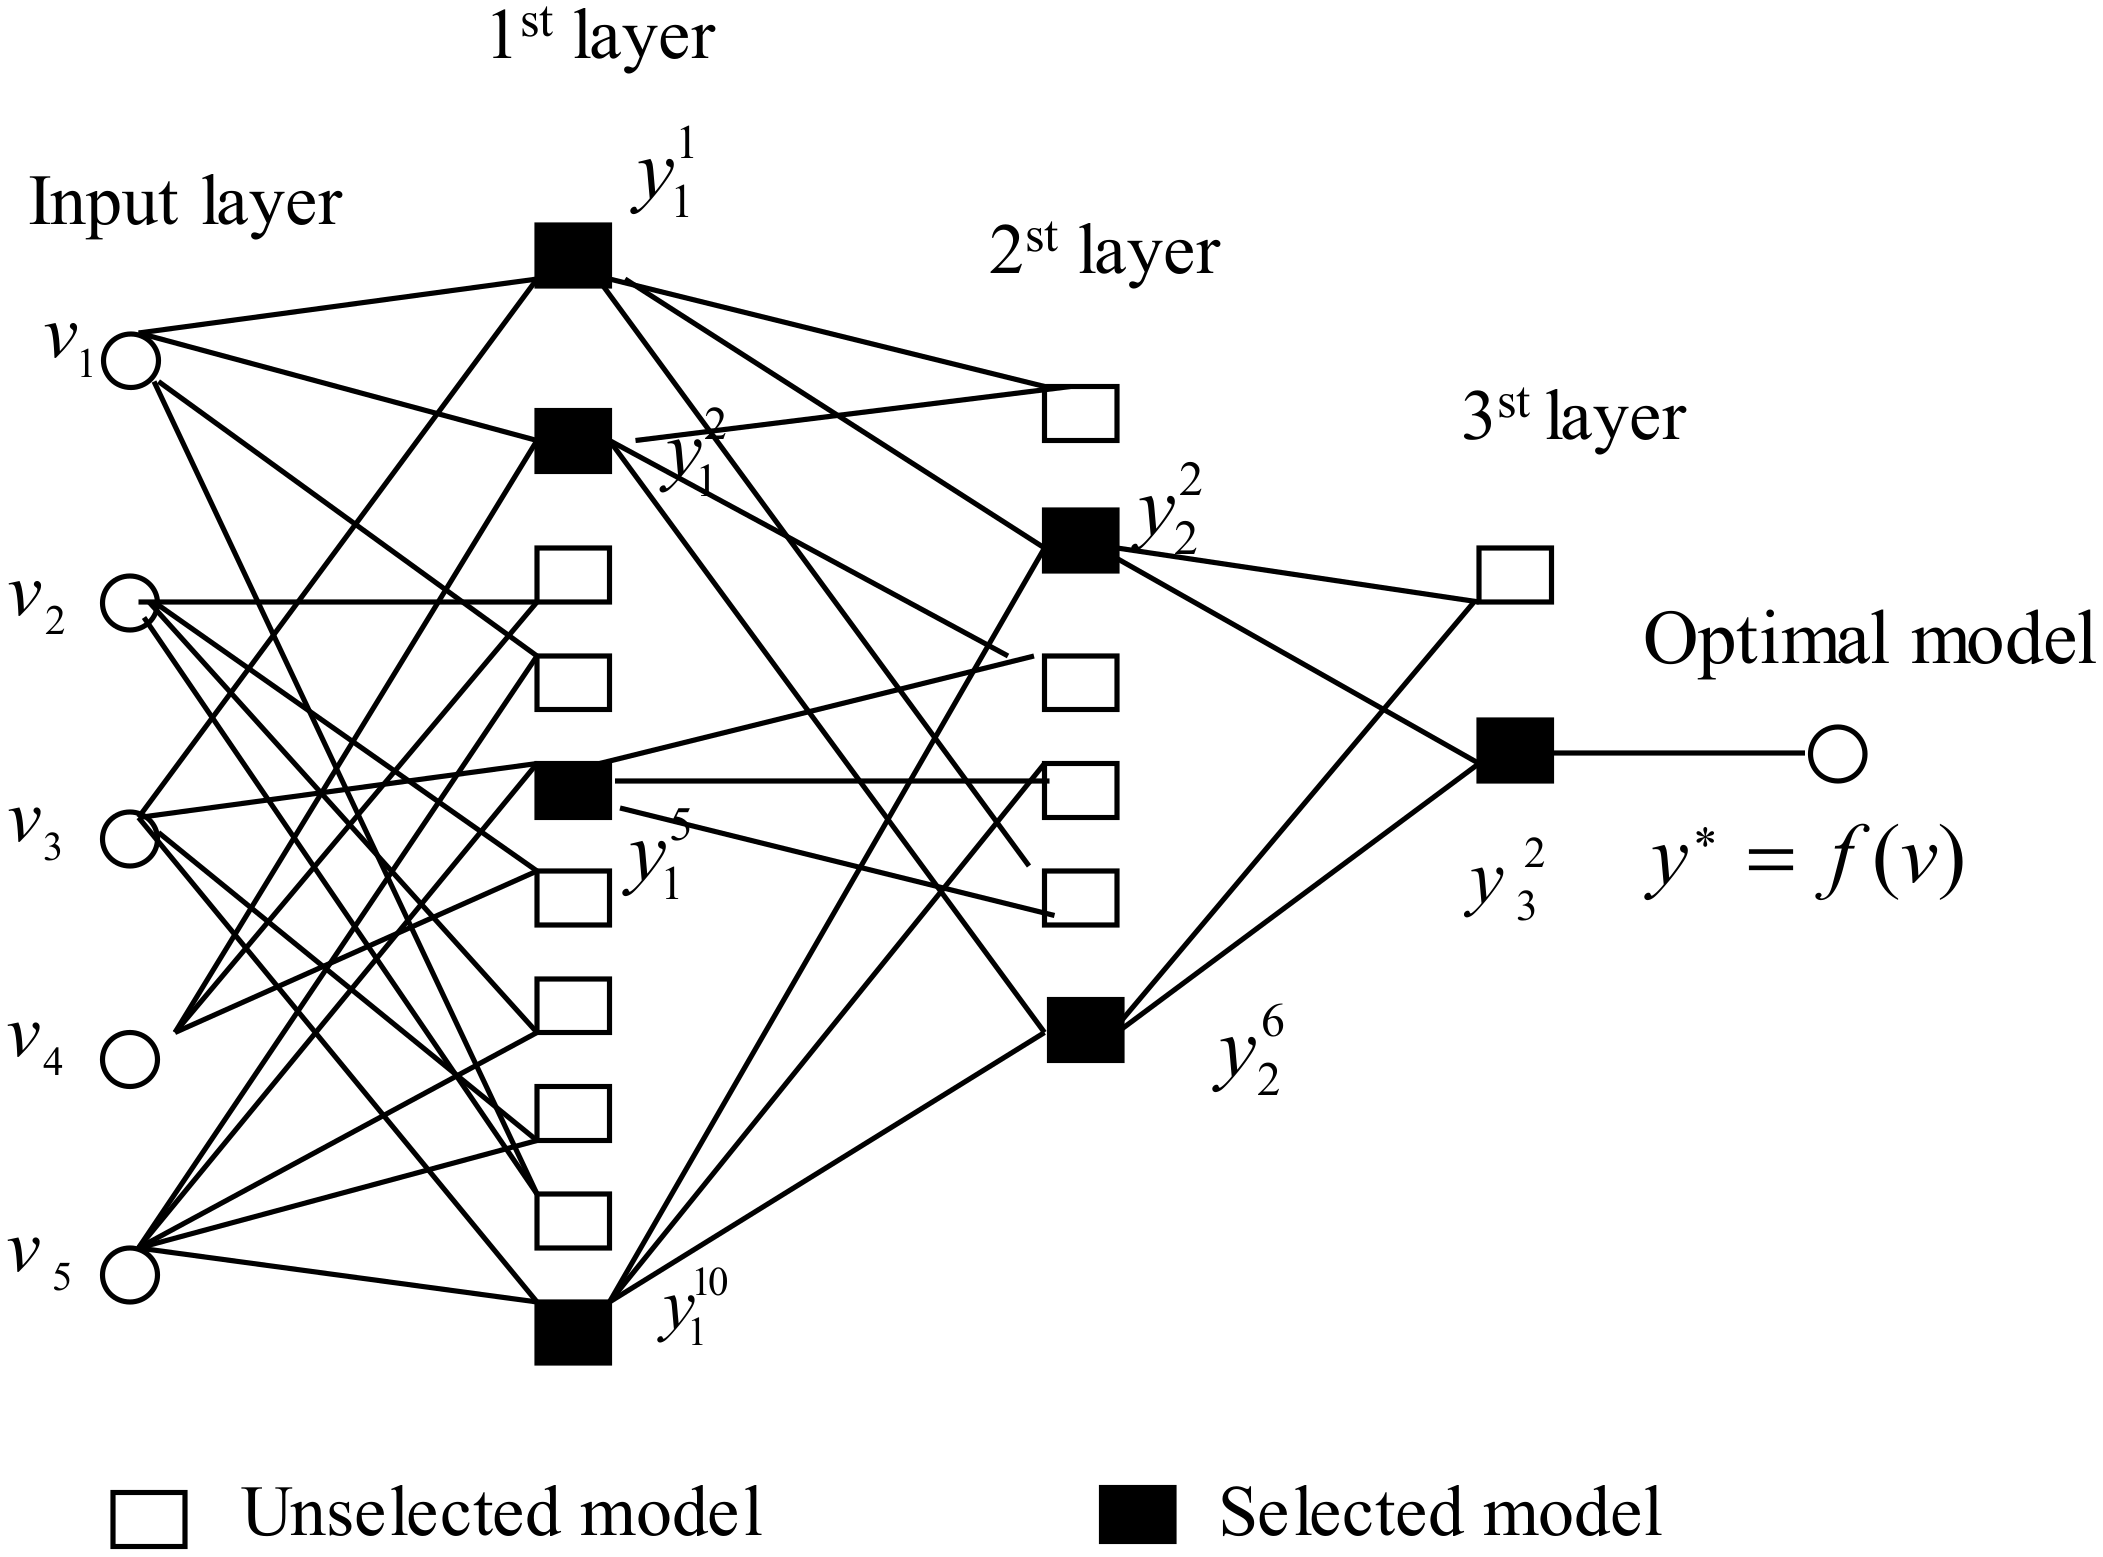

In [19]:
Image('img/gmdh.png', width='50%')

В настоящее время метод вызывает значительный интерес у исследователей. Методу посвящено много публикаций за последние годы. Современные модификации метода предполагают использование эволюционного моделирования и нечеткой логики.

### Эксперименты

В scikit-learn данная модель не реализована напрямую. Она реализована в библиотеке [GmdhPy.](https://github.com/kvoyager/GmdhPy)

In [20]:
from gmdhpy import gmdh

In [21]:
model = gmdh.Regressor()
model.fit(boston_X_train, boston_y_train)
y_pred = model.predict(boston_X_test)
result = mean_absolute_error(boston_y_test, y_pred)
print(model)
print('MAE={}'.format(result))

train layer0 in 0.07 sec
train layer1 in 0.21 sec
train layer2 in 0.22 sec
train layer3 in 0.23 sec
train layer4 in 0.22 sec
train layer5 in 0.23 sec
train layer6 in 0.22 sec
train layer7 in 0.22 sec
train layer8 in 0.22 sec
train layer9 in 0.22 sec
Self-organizing deep learning polynomial neural network
MAE=3.2568485867598214


In [22]:
model = gmdh.Regressor(ref_functions=('linear_cov', 'quadratic', 'cubic', 'linear'))
model.fit(boston_X_train, boston_y_train, validation_data=(boston_X_test, boston_y_test))
y_pred = model.predict(boston_X_test)
result = mean_absolute_error(boston_y_test, y_pred)
print(model)
print('MAE={}'.format(result))

train layer0 in 0.34 sec
train layer1 in 1.24 sec
train layer2 in 1.30 sec
train layer3 in 1.27 sec
train layer4 in 1.20 sec
train layer5 in 1.29 sec
train layer6 in 1.27 sec
train layer7 in 1.36 sec
train layer8 in 1.26 sec
train layer9 in 1.21 sec
train layer10 in 1.16 sec
train layer11 in 1.20 sec
train layer12 in 1.22 sec
train layer13 in 1.25 sec
train layer14 in 1.18 sec
train layer15 in 1.23 sec
train layer16 in 1.30 sec
train layer17 in 1.36 sec
train layer18 in 1.16 sec
train layer19 in 1.15 sec
train layer20 in 1.28 sec
train layer21 in 1.29 sec
train layer22 in 1.21 sec
train layer23 in 1.29 sec
train layer24 in 1.21 sec
train layer25 in 1.19 sec
train layer26 in 1.19 sec
Self-organizing deep learning polynomial neural network
MAE=2.1384971541397326


In [23]:
# Результаты
array_labels2 = array_labels + ['GMDH_1', 'GMDH_2']
array_mae2 = array_mae + [3.2568485867598214, 2.1384971541397326]

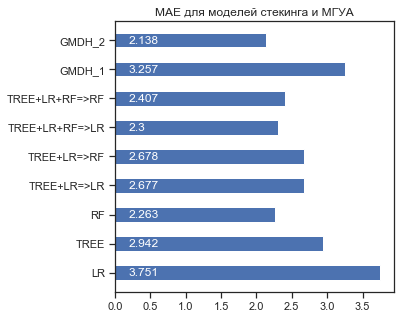

In [24]:
vis_models_quality(array_mae2, array_labels2, 'MAE для моделей стекинга и МГУА')

### Дополнительные источники (по МГУА)

- [Статья о МГУА на machinelearning.ru](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%93%D0%A3%D0%90)
- [Обзор задач, решаемых по алгоритмам Метода Группового Учета Аргументов](http://www.gmdh.net/articles/rus/obzorzad.pdf)

## [Automated machine learning - AutoML](https://ru.wikipedia.org/wiki/%D0%90%D0%B2%D1%82%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD)

#### Определение из Википедии:

Автоматическое обучение машин (AutoML) — это процесс автоматизации сквозного процесса применения обучения машины к задачам реального мира. В типичном приложении обучения машины практический работник должен применить подходящие методы предварительной обработки данных, конструирования признаков, выделения признаков и выбора признаков, которые делают набор данных пригодным для обучения машин. После этих шагов работник должен осуществить выбор алгоритма и оптимизацию гиперпараметров для максимизации прогнозируемой производительности конечной модели обучения машин. Поскольку многие из этих шагов не могут осуществить люди, не будучи экспертами, был предложен AutoML как основанное на искусственном интеллекте решение для всё возрастающей необходимости применения обучения машин. Автоматизация сквозного процесса применения обучения машин даёт преимущество получения более простых решений, более быстрого создания таких решений и моделей, которые часто превосходят модели, построенные вручную. 

Наиболее часто используется библиотека [TPOT.](https://github.com/EpistasisLab/tpot)

**Внимание:** при использовании windows TPOT иногда приводит к разрушению дистрибутива anaconda.

### Дополнительные источники (по AutoML)
- [7 фреймворков автоматического машинного обучения](https://proglib.io/p/auto-ml)
- [Что такое автоматизированное машинное обучение (AutoML)](https://habr.com/ru/post/449260/)
- [AutoML is Overhyped](https://towardsdatascience.com/automl-is-overhyped-1b5511ded65f)